Viba Courtney-Battista

vcourtneybattista@gmail.com

07864956064

# Objective: 
Develop a Python-based trading bot that employs machine learning techniques to predict stock prices using fundamental data, with the aim of creating an equity market neutral strategy.
# Data Specifications:
Attached you will find the data for the task in CSV format.
Label: for the machine learning model, the target variable is the Volume Weighted Average Price (VWAP), which serves as the basis for both predicting future prices and executing trades. Predictions should forecast the VWAP at least thirty days into the future, but longer if your model prefers it. You need to open and close positions at the VWAP the day AFTER the signal is triggered.
Features: Utilize the provided fundamental data as features for your model. You are expected to normalize/engineer these features as you see fit. The most straightforward approach might be to create new rank features of the raw features and train the model on the new rank features.
# New Features Recommendation:
Calculate and include z-scores for Price-to-Earnings (P/E), Price-to-Book (P/B), and Dividend Yield based on a 5-year lookbacks
Consider creating and incorporating technical indicators, but these are not required
Trading Costs: Assume $1 million positions (both long and short) with a total transaction cost of 14 basis points (bps) per round-trip trade.
 
# Output Requirements:
Trading Bot: The trading bot should use the fundamental data to predict stock prices and buy/long the decile with the highest expected return and sell/short the decile with the lowest expected return based on your model's predictions. The portfolio should be market neutral i.e. the total long positions and short positions are equal
# Performance Statistics:
Primary goal: Maximize the Sharpe ratio
Include both machine learning model performance statistics (e.g., accuracy, precision, recall, etc.) and portfolio performance statistics (e.g., Sharpe ratio, annualized return, total return, maximum drawdown, turnover).
Model/feature discussion: which features work best and why? How did you select the model type?

# Additional Discussion Points:
Model Selection: Discuss the model you chose and the rationale behind this choice. Also, mention any alternative models you considered.
Factor Importance: Explore the importance of different features in your model and how this importance varies over time and across sub-sectors or countries.
Tuning: Explain the hyperparameter tuning process, including the hyperparameters you focused on and the reasoning behind your choices.
AutoML Tools: While the primary task is to develop a Python-only trading bot, if you use AutoML tools please let us know and we can tailor the questions more to this.

In [2]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

## Data Cleaning:

The data has various types and multiple missing values, before preparing data for training I will index by time, check for NaN values and interpolate to ensure there are no gaps.

Index by time:

In [3]:
# import the data
PATH_NAME = '/Users/viba/coding_misc/moore_capital/Data_output.csv'
data = pd.read_csv(PATH_NAME)
print(data.keys())
data["date"] = pd.to_datetime(data["DATE"], format='%d/%m/%Y')
data.set_index("date", inplace=True)
data.drop(columns=["DATE"], inplace=True)
data

Index(['ID', 'DATE', 'VWAP', 'PE_RATIO', 'PX_TO_BOOK_RATIO', 'DVD_YIELD',
       '4W_EPS_CHG', '8W_EPS_CHG_BF', '12W_EPS_CHG', '4W_DPS_CHG'],
      dtype='object')


/var/folders/f3/60kl6lyx3w9bwrb2k298t_bm0000gn/T/ipykernel_54488/3657450447.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(PATH_NAME)


,ID,VWAP,PE_RATIO,PX_TO_BOOK_RATIO,DVD_YIELD,4W_EPS_CHG,8W_EPS_CHG_BF,12W_EPS_CHG,4W_DPS_CHG
date,,,,,,,,,
2013-10-04,BAMI IM Equity,7.044104,6.529261,0.249196,2.602121,-0.836820084,5.896723,-4.435483871,3.311258
2013-10-05,BAMI IM Equity,7.044104,6.524330,0.249182,2.605978,-0.836820084,5.891079,-4.435483871,3.311258
2013-10-06,BAMI IM Equity,7.044104,6.519407,0.249167,2.609834,-0.836820084,6.000838,-4.435483871,3.311258
2013-10-07,BAMI IM Equity,7.319576,6.754070,0.258315,2.520979,-0.836820084,5.995326,-4.435483871,1.628664
2013-10-08,BAMI IM Equity,7.483704,6.769355,0.259079,2.517100,0,5.989822,-4.435483871,5.050505
...,...,...,...,...,...,...,...,...,...
2023-09-30,PEO PW Equity,100.654875,6.451165,0.929351,11.036089,0.269592005,-0.367685,8.896580611,9.789234
2023-10-01,PEO PW Equity,100.654875,6.453481,0.929221,11.039309,0.269592005,-0.375537,8.896580611,9.789234
2023-10-02,PEO PW Equity,99.866015,6.327258,0.910592,11.266862,0.269592005,-1.064339,8.896580611,9.789234


Check for NaNs

In [4]:

# Display the data types of each column
print("Data Types:")
print(data.dtypes)

# Check for missing values in the data
print("\nMissing Values:")
print(data.isnull().sum())

# Interpolate missing values
data.interpolate(method='time', inplace=True) # Only use if the index is DateTime

# Check if there are still any missing values
print("\nMissing Values After Cleaning:")
print(data.isnull().sum())

# Convert all percentage changes to float
cols_to_convert = ['4W_EPS_CHG', '8W_EPS_CHG_BF', '12W_EPS_CHG', '4W_DPS_CHG']
for col in cols_to_convert:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    
# Validate changes
print("\nData Types After Conversion:")
print(data.dtypes)


Data Types:
ID                   object
VWAP                float64
PE_RATIO            float64
PX_TO_BOOK_RATIO    float64
DVD_YIELD           float64
4W_EPS_CHG           object
8W_EPS_CHG_BF       float64
12W_EPS_CHG          object
4W_DPS_CHG          float64
dtype: object

Missing Values:
ID                     0
VWAP                3408
PE_RATIO               0
PX_TO_BOOK_RATIO       0
DVD_YIELD              0
4W_EPS_CHG             0
8W_EPS_CHG_BF          0
12W_EPS_CHG            0
4W_DPS_CHG             0
dtype: int64

Missing Values After Cleaning:
ID                  0
VWAP                0
PE_RATIO            0
PX_TO_BOOK_RATIO    0
DVD_YIELD           0
4W_EPS_CHG          0
8W_EPS_CHG_BF       0
12W_EPS_CHG         0
4W_DPS_CHG          0
dtype: int64

Data Types After Conversion:
ID                   object
VWAP                float64
PE_RATIO            float64
PX_TO_BOOK_RATIO    float64
DVD_YIELD           float64
4W_EPS_CHG          float64
8W_EPS_CHG_BF       float6

/var/folders/f3/60kl6lyx3w9bwrb2k298t_bm0000gn/T/ipykernel_54488/1915631618.py:10: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='time', inplace=True) # Only use if the index is DateTime


Check we have a complete set of data after interpolation:

In [5]:
data.groupby(by="ID")["VWAP"].count()

ID
ABN NA Equity       3653
ACA FP Equity       3653
AIBG ID Equity      3653
AZA SS Equity       3653
BAMI IM Equity      3653
BARC LN Equity      3653
BBVA SQ Equity      3653
BCP PL Equity       3653
BCVN SE Equity      3653
BG AV Equity        3653
BIRG ID Equity      3653
BKT SQ Equity       3653
BMPS IM Equity      3653
BNP FP Equity       3653
BPE IM Equity       3653
BPSO IM Equity      3653
CABK SQ Equity      3653
CBK GY Equity       3653
CMBN SE Equity      3653
DANSKE DC Equity    3653
DBK GY Equity       3653
DNB NO Equity       3653
EBS AV Equity       3653
FBK IM Equity       3653
GLE FP Equity       3653
HSBA LN Equity      3653
INGA NA Equity      3653
INVP LN Equity      3653
ISP IM Equity       3653
JYSK DC Equity      3653
KBC BB Equity       3653
LLOY LN Equity      3653
NDA FH Equity       3653
NWG LN Equity       3653
PEO PW Equity       3653
PKO PW Equity       3653
RBI AV Equity       3653
RILBA DC Equity     3653
SAB SQ Equity       3653
SAN SQ Equity       36

In [6]:
print(data.isna().sum())


ID                   0
VWAP                 0
PE_RATIO             0
PX_TO_BOOK_RATIO     0
DVD_YIELD            0
4W_EPS_CHG          33
8W_EPS_CHG_BF        0
12W_EPS_CHG         76
4W_DPS_CHG           0
dtype: int64


In [7]:
data

,ID,VWAP,PE_RATIO,PX_TO_BOOK_RATIO,DVD_YIELD,4W_EPS_CHG,8W_EPS_CHG_BF,12W_EPS_CHG,4W_DPS_CHG
date,,,,,,,,,
2013-10-04,BAMI IM Equity,7.044104,6.529261,0.249196,2.602121,-0.836820,5.896723,-4.435484,3.311258
2013-10-05,BAMI IM Equity,7.044104,6.524330,0.249182,2.605978,-0.836820,5.891079,-4.435484,3.311258
2013-10-06,BAMI IM Equity,7.044104,6.519407,0.249167,2.609834,-0.836820,6.000838,-4.435484,3.311258
2013-10-07,BAMI IM Equity,7.319576,6.754070,0.258315,2.520979,-0.836820,5.995326,-4.435484,1.628664
2013-10-08,BAMI IM Equity,7.483704,6.769355,0.259079,2.517100,0.000000,5.989822,-4.435484,5.050505
...,...,...,...,...,...,...,...,...,...
2023-09-30,PEO PW Equity,100.654875,6.451165,0.929351,11.036089,0.269592,-0.367685,8.896581,9.789234
2023-10-01,PEO PW Equity,100.654875,6.453481,0.929221,11.039309,0.269592,-0.375537,8.896581,9.789234
2023-10-02,PEO PW Equity,99.866015,6.327258,0.910592,11.266862,0.269592,-1.064339,8.896581,9.789234


# Visualise the data:

Visualising the data is always useful to give an intuition into the underlying distribution. For example by observation this paths seem to be non-differentiable stochastic processes. Considering the price is weighted by volume I have not standardised the data, however trying this may improve results. Another property worth noting is potential periodicity, modelling the noise in financial time series can potentially be done by considering the frequency domain of the series, possibly fitting it with Welch's method as the data is aperiodic.

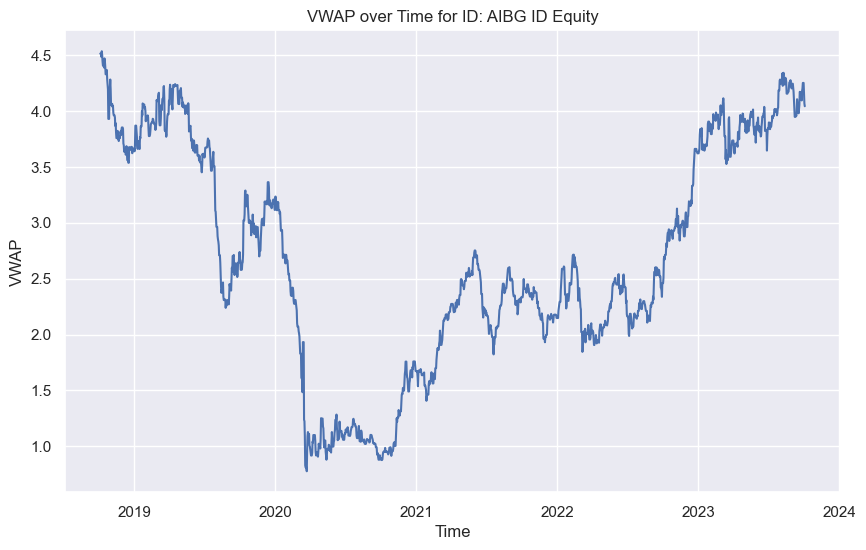

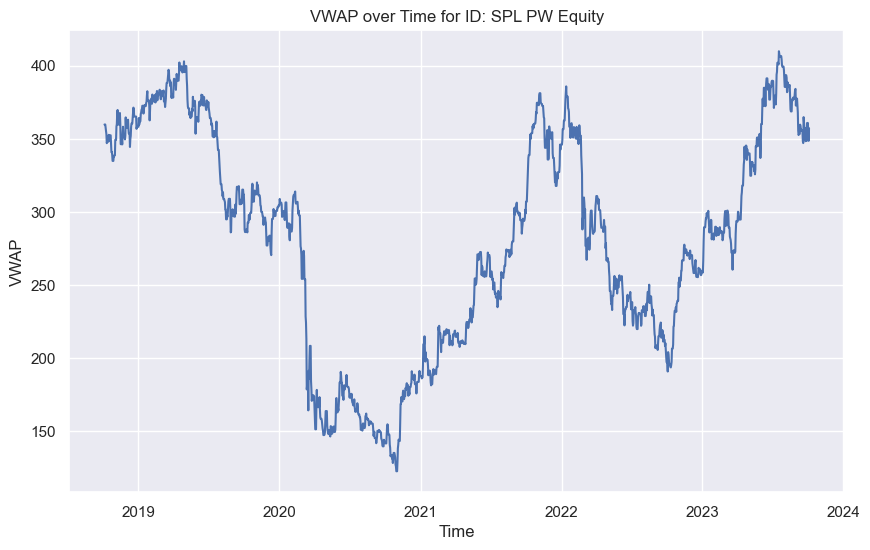

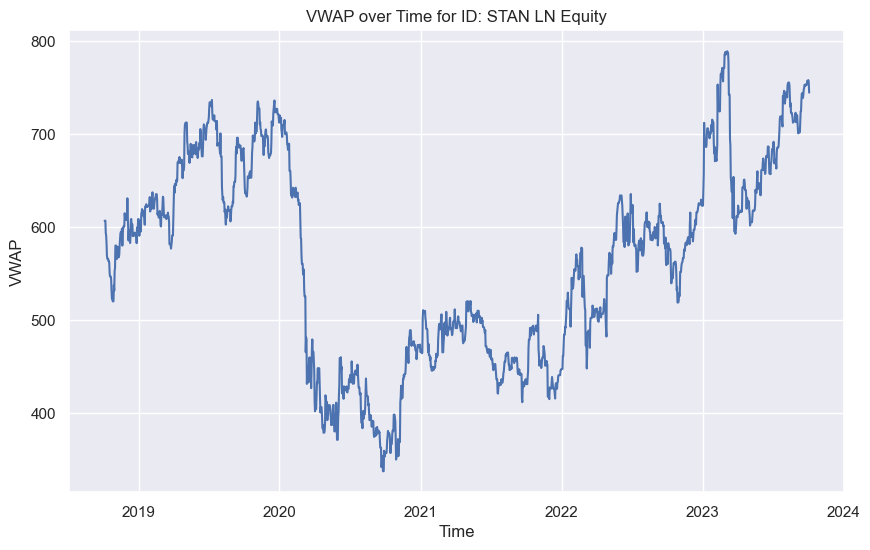

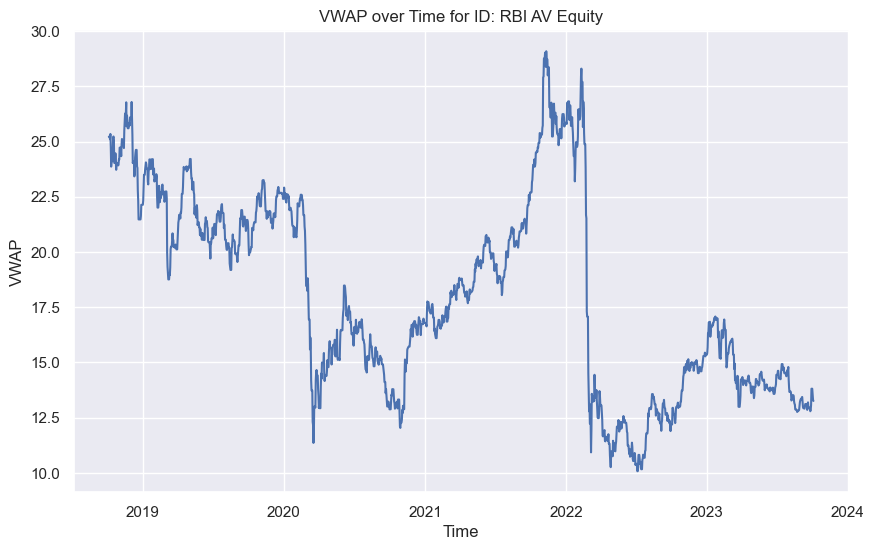

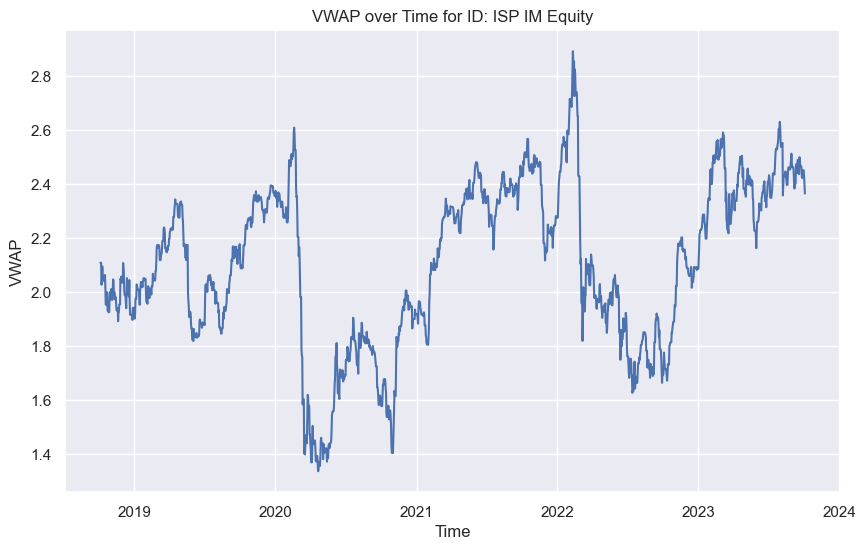

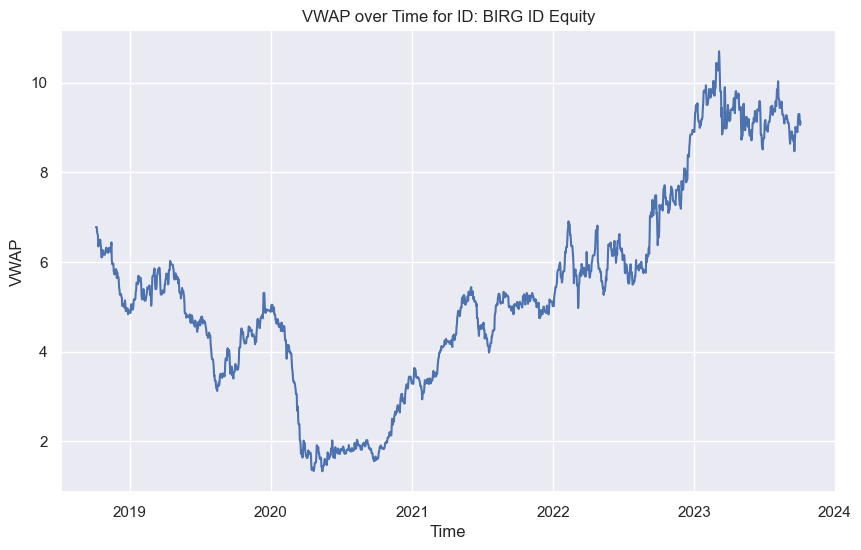

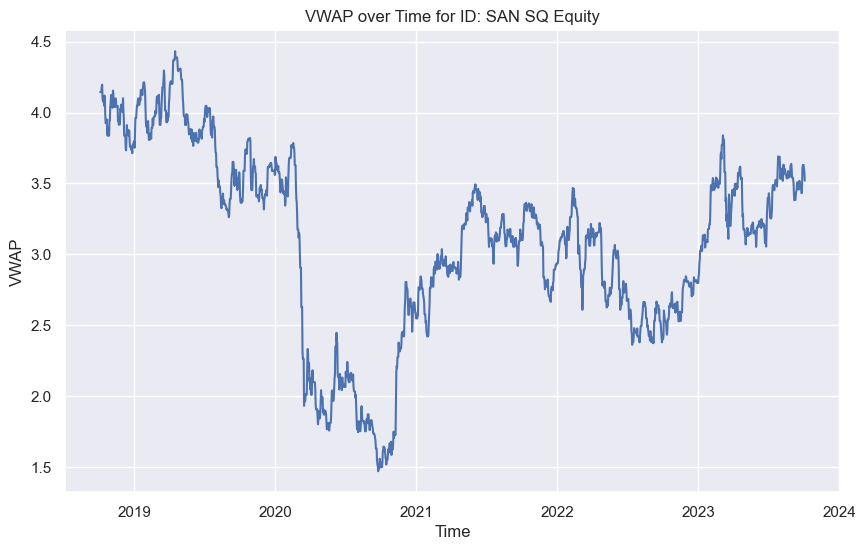

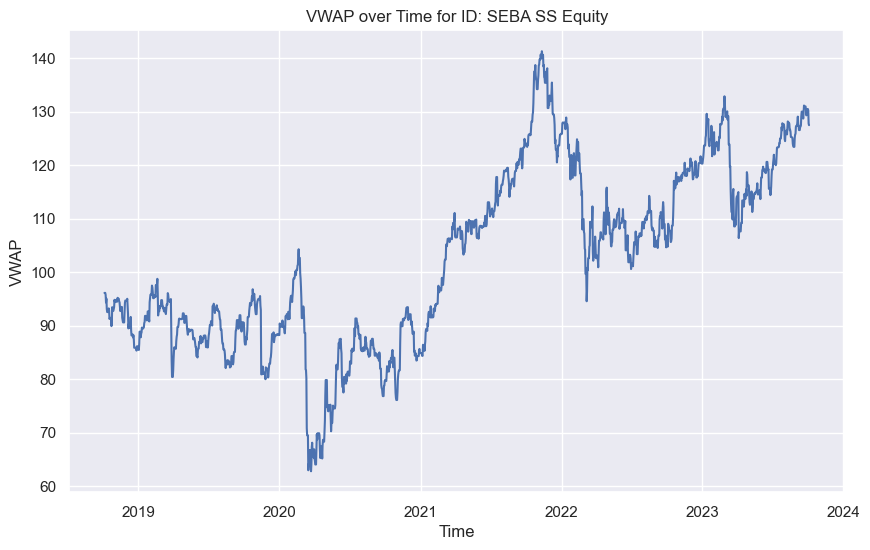

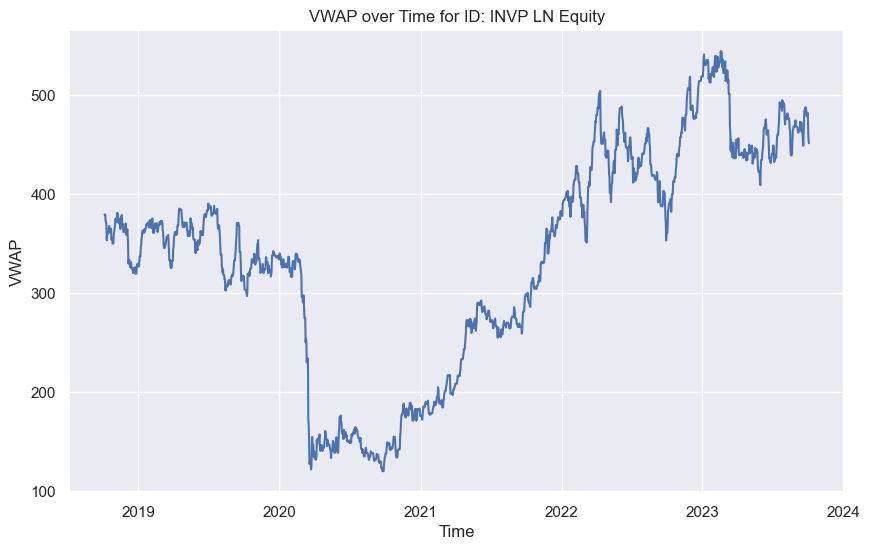

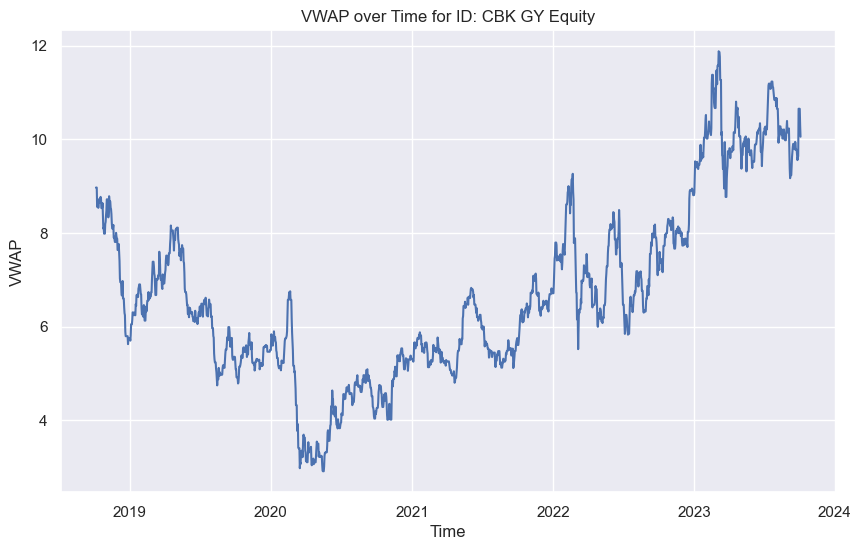

In [40]:
# Sample 10 random IDs from the data
sample_ids = np.random.choice(data['ID'].unique(), size=10, replace=False)

# Group data by ID
grouped = data.groupby('ID')

# Create a new plot for each sampled ID
for id_value in sample_ids:
    plt.figure(figsize=(10, 6))
    subset = grouped.get_group(id_value)  # Get the subset of data for the specific ID
    plt.plot(subset.index, subset['VWAP'], linestyle='-')
    plt.title(f'VWAP over Time for ID: {id_value}')
    plt.xlabel('Time')
    plt.ylabel('VWAP')
    plt.grid(True)
    plt.show()


## Model preparation

Considering the prices are weighted against volume and we are taking company revenue, px to book ratio and dividend yield as features, I have assumed the underlying distribution is shared for each stock ID. This is because taking more features about a stock into consideration reduces the uniqueness of each stocks distribution.

To begin extracting important features I have taken the 5 year lookback Z-Scores for 'PE_RATIO', 'PX_TO_BOOK_RATIO' and 'DVD_YIELD' as suggested in the case study. Since there is insufficient data to store values for the first five years I have removed them for simplicity under the assumption there is plenty of data after removing the first five years.

In [10]:
# Features to calculate Z-scores for
features = ['PE_RATIO', 'PX_TO_BOOK_RATIO', 'DVD_YIELD']
lookback_period = 365 * 5  # 5 years

# Calculate rolling mean, standard deviation, and Z-score for each feature, grouped by 'ID'
for feature in ['PE_RATIO', 'PX_TO_BOOK_RATIO', 'DVD_YIELD']:
    for id_value, group in data.groupby('ID'):
        # Calculate rolling mean and standard deviation
        rolling_mean = group[feature].rolling(window=lookback_period, min_periods=1).mean()
        rolling_std = group[feature].rolling(window=lookback_period, min_periods=1).std()

        # Avoid division by zero by replacing 0 standard deviations with NaN
        rolling_std.replace(0, np.nan, inplace=True)

        # Compute Z-scores and assign them back to the respective place in the DataFrame
        z_scores = (group[feature] - rolling_mean) / rolling_std
        data.loc[data['ID'] == id_value, f'{feature}_ZSCORE'] = z_scores

In [11]:
#check for nan
print(data.isna().sum())
#cut off first 5 years
cutoff_date = data.index.min() + pd.DateOffset(years=5)
# Filter out rows that are older than five years from the earliest date in your DataFrame
data = data[data.index > cutoff_date]
print(data.isna().sum())

ID                            0
VWAP                          0
PE_RATIO                      0
PX_TO_BOOK_RATIO              0
DVD_YIELD                     0
4W_EPS_CHG                   33
8W_EPS_CHG_BF                 0
12W_EPS_CHG                  76
4W_DPS_CHG                    0
PE_RATIO_ZSCORE            4310
PX_TO_BOOK_RATIO_ZSCORE    6325
DVD_YIELD_ZSCORE           5331
dtype: int64
ID                           0
VWAP                         0
PE_RATIO                     0
PX_TO_BOOK_RATIO             0
DVD_YIELD                    0
4W_EPS_CHG                   5
8W_EPS_CHG_BF                0
12W_EPS_CHG                  5
4W_DPS_CHG                   0
PE_RATIO_ZSCORE              0
PX_TO_BOOK_RATIO_ZSCORE    775
DVD_YIELD_ZSCORE             0
dtype: int64


In [12]:
# interpolate missing values
data.interpolate(method='time', inplace=True)
data.isna().sum()

/var/folders/f3/60kl6lyx3w9bwrb2k298t_bm0000gn/T/ipykernel_54488/644228830.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='time', inplace=True)
/var/folders/f3/60kl6lyx3w9bwrb2k298t_bm0000gn/T/ipykernel_54488/644228830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.interpolate(method='time', inplace=True)


ID                         0
VWAP                       0
PE_RATIO                   0
PX_TO_BOOK_RATIO           0
DVD_YIELD                  0
4W_EPS_CHG                 0
8W_EPS_CHG_BF              0
12W_EPS_CHG                0
4W_DPS_CHG                 0
PE_RATIO_ZSCORE            0
PX_TO_BOOK_RATIO_ZSCORE    0
DVD_YIELD_ZSCORE           0
dtype: int64

In [13]:
# convert datatype to float32 except ID column
for col in data.columns:
    if col != 'ID':
        data[col] = data[col].astype(np.float32)


/var/folders/f3/60kl6lyx3w9bwrb2k298t_bm0000gn/T/ipykernel_54488/113711200.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].astype(np.float32)
/var/folders/f3/60kl6lyx3w9bwrb2k298t_bm0000gn/T/ipykernel_54488/113711200.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].astype(np.float32)
/var/folders/f3/60kl6lyx3w9bwrb2k298t_bm0000gn/T/ipykernel_54488/113711200.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Now we have interpolated our data and there are no 'gaps' we can begin creating our targets:

We want the model to predict the next 30 days of VWAP so we set these to be the targets as follows:

In [14]:
data['Future_VWAP'] = data['VWAP'].shift(-30)
data.dropna(subset=['Future_VWAP'], inplace=True)


/var/folders/f3/60kl6lyx3w9bwrb2k298t_bm0000gn/T/ipykernel_54488/99553979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Future_VWAP'] = data['VWAP'].shift(-30)
/var/folders/f3/60kl6lyx3w9bwrb2k298t_bm0000gn/T/ipykernel_54488/99553979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['Future_VWAP'], inplace=True)


In [15]:
data.isna().sum()

ID                         0
VWAP                       0
PE_RATIO                   0
PX_TO_BOOK_RATIO           0
DVD_YIELD                  0
4W_EPS_CHG                 0
8W_EPS_CHG_BF              0
12W_EPS_CHG                0
4W_DPS_CHG                 0
PE_RATIO_ZSCORE            0
PX_TO_BOOK_RATIO_ZSCORE    0
DVD_YIELD_ZSCORE           0
Future_VWAP                0
dtype: int64

Now we have data and targets we take the specified feature columns and targets and create a dictionary to store the train and test data. We should train on each ID separately and within each ID fit the entire model, hence the dictionary contains a dictionary for each ID and this dictionary stores the train and test data and targets to use later.

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Feature and target columns
feature_cols = ['VWAP', 'PE_RATIO_ZSCORE', 'PX_TO_BOOK_RATIO_ZSCORE', 'DVD_YIELD_ZSCORE']
target_col = 'Future_VWAP'

# Dictionary to store training and testing datasets for each ID
train_test_data = {}

# Split ratio for training and testing
train_ratio = 0.8

# Iterate over each unique ID to create separate training and testing datasets
for id_value in data['ID'].unique():
    # Subset the DataFrame for the current ID
    id_data = data[data['ID'] == id_value].copy()
    
    # Ensure the data is sorted by date (if not already)
    id_data.sort_index(inplace=True)
    
    # Define the size of the training dataset
    train_size = int(len(id_data) * train_ratio)
    
    # Split the data into features (X) and target (y)
    X = id_data[feature_cols]
    y = id_data[target_col]
    
    # Create training and testing sets
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Store the split data in our dictionary
    train_test_data[id_value] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }
train_test_data

{'BAMI IM Equity': {'X_train':                 VWAP  PE_RATIO_ZSCORE  PX_TO_BOOK_RATIO_ZSCORE  \
  date                                                             
  2018-10-05  1.972514        -1.560267                -0.923850   
  2018-10-06  1.972514        -1.560079                -0.924117   
  2018-10-07  1.972514        -1.543009                -0.924377   
  2018-10-08  1.871794        -1.660619                -1.046710   
  2018-10-09  1.846515        -1.638884                -1.025616   
  ...              ...              ...                      ...   
  2022-09-29  2.651208        -1.056693                 0.524706   
  2022-09-30  2.685399        -1.002421                 0.616809   
  2022-10-01  2.685399        -1.002899                 0.618168   
  2022-10-02  2.685399        -1.003375                 0.619521   
  2022-10-03  2.750187        -0.902749                 0.789174   
  
              DVD_YIELD_ZSCORE  
  date                          
  2018-10-05      

## Choice of model

Predicting financial data is a complex task, and perhaps a more complex model is best suited. To begin I am using a Gradient boosting regressor as the underlying distribution is likely non-linear. 
An alternative method that would be my first choice for a longer case study would be considering features as a rough path in time, calculating a time series of Signature transforms (A truncated formal tensor series containing a very large amount of the total information in the data up to arbitrary precision, avoiding assumptions about the importance of the length of our rolling windows) for this path, and then implimenting regression.
After fitting this model I store necessary metrics such as RMSE to reflect on the models evaluation, these metrics can be improved by fine tuning the hyperparameters and training for a longer max-depth. To improve on this section I would iterate over the hyperparameter potential values and extract the ones that give the best fit model.
As well as this I store the predictions to calculate the financial statistics and trading strategy.

In [20]:
import xgboost as xgb
# Dictionary to store models and their metrics for each ID
xgb_models = {}

for id_value, datasets in train_test_data.items():
    # Initialize the XGBoost Regressor
    xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100, random_state=42)
    
    # Train the model
    xgb_reg.fit(datasets['X_train'], datasets['y_train'])
    
    # Make predictions on the test set
    predictions = xgb_reg.predict(datasets['X_test'])
    
    # Calculate metrics
    mse = mean_squared_error(datasets['y_test'], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(datasets['y_test'], predictions)
    
    # Store the model and its metrics
    xgb_models[id_value] = {
        'model': xgb_reg,
        'RMSE': rmse,
        'R2': r2,
        'predictions': predictions  # Storing predictions for later analysis
    }


In [21]:
for id_value in xgb_models.keys():
    print(f"ID: {id_value}, RMSE: {rmse_scores[id_value]}, R²: {r2_scores[id_value]}")

ID: BAMI IM Equity, RMSE: 1.4941800300328023, R²: -6.803425279522372
ID: BBVA SQ Equity, RMSE: 1.7431207959977058, R²: -2.627840108478651
ID: SAN SQ Equity, RMSE: 13.024576299188581, R²: -0.08272003303318054
ID: BNP FP Equity, RMSE: 27.40420841178926, R²: 0.057421413784064956
ID: DNB NO Equity, RMSE: 55.1355492034454, R²: -0.36532142524083655
ID: INVP LN Equity, RMSE: 136.87293780924927, R²: -0.08537271584287631
ID: UCG IM Equity, RMSE: 75.8827358659923, R²: -0.14002844174417728
ID: VMUK LN Equity, RMSE: 39.89300215137867, R²: -0.5695311139565098
ID: KBC BB Equity, RMSE: 18.123312772397274, R²: -0.4627282118627367
ID: INGA NA Equity, RMSE: 79.71560447510781, R²: -0.10040814570926804
ID: JYSK DC Equity, RMSE: 142.26536937182235, R²: -0.1869683874989152
ID: EBS AV Equity, RMSE: 41.58243282137174, R²: -0.1104675645390707
ID: SYDB DC Equity, RMSE: 115.61966897226895, R²: -0.712197929279089
ID: ISP IM Equity, RMSE: 180.44437718589353, R²: -0.09012692748989926
ID: HSBA LN Equity, RMSE: 100.7

Here I store the actual and predicted VWAPs for easier use.

In [33]:
predictions_df = pd.DataFrame()

for id_value, model_info in xgb_models.items():
    temp_df = pd.DataFrame({
        'ID': id_value,
        'Actual_VWAP': train_test_data[id_value]['y_test'].values,
        'Predicted_VWAP': model_info['predictions']
    })
    predictions_df = pd.concat([predictions_df, temp_df], ignore_index=True)
predictions_df

,ID,Actual_VWAP,Predicted_VWAP
0,BAMI IM Equity,3.072045,2.707307
1,BAMI IM Equity,3.119113,2.707307
2,BAMI IM Equity,3.119113,2.690553
3,BAMI IM Equity,3.119113,2.715662
4,BAMI IM Equity,3.173951,2.715662
...,...,...,...
17557,PEO PW Equity,100.654877,114.206314
17558,PEO PW Equity,100.654877,110.109543
17559,PEO PW Equity,99.866013,106.672295
17560,PEO PW Equity,98.382065,106.672295


# Computing the financial statistics and investment strategy

Here I create a dictionary and store the highest and lowest percentage change IDs for the trading strategy.

In [34]:
predictions_df['Expected_Percent_Change'] = (predictions_df['Predicted_VWAP'] - predictions_df['Actual_VWAP']) / predictions_df['Actual_VWAP']
predictions_df['Rank'] = predictions_df['Expected_Percent_Change'].rank(ascending=False)
top_decile_threshold = predictions_df['Rank'].quantile(0.1)  # Adjust for top decile
bottom_decile_threshold = predictions_df['Rank'].quantile(0.9)  # Adjust for bottom decile

predictions_df['Position'] = 0  # Neutral by default
predictions_df.loc[predictions_df['Rank'] <= top_decile_threshold, 'Position'] = 1   # Long top expected increases
predictions_df.loc[predictions_df['Rank'] >= bottom_decile_threshold, 'Position'] = -1  # Short top expected decreases



Given the transaction cost I store the return and net return for later calculations

In [38]:
# Constants
TRANSACTION_COST_RATE = 0.0014  # 14 basis points per round-trip
NUM_STOCKS_LONG_SHORT = len(predictions_df) // 10  # Number of stocks in top and bottom deciles, assuming equal division for long and short

# Calculate the amount of capital allocated per position
# Since we're maintaining market neutrality, the total investment is split equally among long and short positions
capital_per_position = 1_000_000 / NUM_STOCKS_LONG_SHORT  # $1 million divided by the number of stocks in each decile

# Update Return calculation to reflect the Expected_Percent_Change
# 'Return' now reflects the gain or loss based on the expected change, rather than raw price differences
predictions_df['Return'] = predictions_df['Expected_Percent_Change'] * predictions_df['Position']
# Calculate Net Return after accounting for transaction costs; costs apply when a position is taken (abs(Position) == 1)
predictions_df['Net_Return'] = predictions_df['Return'] - (TRANSACTION_COST_RATE * predictions_df['Position'].abs())

# Calculate financial impact considering the allocated capital per position
# The financial impact considers the net return (after costs) times the capital allocated to each position
predictions_df['Financial_Impact'] = capital_per_position * predictions_df['Net_Return']


Finally I compute the total return, annual return and Sharpe Ratio to evaluate the trading strategy. In a longer case study I would consider different model complexities and fine tune the hyperparameters for an optimised model to be used for executable trading strategies.

In [39]:
# Total portfolio return
total_return = predictions_df['Financial_Impact'].sum()

# Assuming an approximation since we lack explicit temporal data
# Note: These are simpler as we don't have the exact dates
annualized_return = total_return / len(predictions_df) * 365  # Simplify assuming 252 trading days per year

# Sharpe ratio calculation (assuming risk-free rate is negligible for simplification)
average_daily_return = predictions_df['Financial_Impact'].mean()
std_dev_daily_return = predictions_df['Financial_Impact'].std()
sharpe_ratio = (average_daily_return / std_dev_daily_return) * np.sqrt(365)


print(f"Total Return: {total_return}")
print(f"Annualized Return: {annualized_return}")
print(f"Sharpe Ratio: {sharpe_ratio}")


Total Return: 14132668.9839956
Annualized Return: 293726.46504716965
Sharpe Ratio: 2.0213584350896987


# Conclusion

This model can be improved in multiple ways as discussed: fine tuning, training on more data, including more features etc. This notebook serves as an outline to creating profitable investment strategies, the statistics calculated are adapted such that the results will be relevent even when changing the model.